In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube

In [5]:
def rejection_sampling(pdf, n=1000, xmin=0, xmax=.98):
    x=torch.linspace(xmin,xmax,1000)  
    y=pdf(x)  
    pmin=0.  
    pmax=y.max()  
   
    naccept=0  
   
    ran=[] # output list of random numbers  
    while naccept<n:  
        x = (xmax - xmin) * torch.rand(1) + xmin  
        y = (pmax - pmin) * torch.rand(1) + pmin   
        
        if y<pdf(x):  
            ran.append(x)  
            naccept=naccept+1  
    
    return np.asarray(ran)  

def generate_random_symmetric_matrix(dim):
    M_random = torch.rand((dim,dim)) - 0.5
    return 0.5 * (M_random.T + M_random)

def eigenvalue_of_eigenvector(x):
    return ((x @ A @ x.T) / (x @ x.T)).item()

def derivative(y, x):
    dim = y.shape[-1]
    dydx = torch.zeros_like(y, dtype=y.dtype)
    for i in range(dim):
        yi = y[:,i].sum()
        dydx[:,i] = torch.autograd.grad(yi, x, create_graph=True, retain_graph=True, allow_unused=True)[0].squeeze()
    return dydx

In [27]:
class EigenPiNN(nn.Module):
    def __init__(self, dim, hidden_layers):
        super().__init__()

        # Hidden Layers are assumed to be fully connected acyclic ReLu nodes with hidden_layer nodes each.
        # The ODE leading to an eigenvector fix point is first order in "time"
        # It is thus possible to use a ReLU activation. Only second derivatives would be problematic 
        # (as they vanish)
        prev_nodes_per_layer = 1;
        hidden = []
        for nodes_per_layer in hidden_layers:
            hidden += [nn.Linear(prev_nodes_per_layer, nodes_per_layer), nn.ReLU()]
            prev_nodes_per_layer = nodes_per_layer
        
        self.ff_relu_graph = nn.Sequential(*hidden)
            
        # Output Layer is assumed to be linear
        self.output = nn.Linear(prev_nodes_per_layer, dim)
        
    def forward(self, x): 
        return self.output(self.ff_relu_graph(x))

In [28]:
def f(x, A):
    first_term = (x[:,None,:] @ (x[:,None,:] @ x[:,:,None] * A)).squeeze()
    second_term = (x[:,None,:] @ A @ x[:,:,None] @ x[:,None,:]).squeeze()
    return first_term - second_term

In [29]:
def eigendecomposition(A, verbose=True):
    
    # Coordinate Transformations
    def dtau_dt_inv_tan(tau):
        """
        Assuming t = tan(pi/2 * tau) this is (dtau/dt)^(-1)
        """
        return torch.pi/(2 * torch.cos(torch.pi/2 * tau)**2)

    def dtau_dt_inv_arctanh(tau):
        """
        Assuming t = arctanh(tau) this is (dtau/dt)^(-1)
        """
        return 1.0/(1.0 - tau**2)
    
    dim = A.shape[0]
    
    #Initial Condition
    y_0 = torch.rand(dim).reshape(1,dim)
    y_0 /= torch.sqrt(y_0 @ y_0.T).item()
    y_0 = y_0.reshape(1,-1)
    
    # Hyperparameters for model and learning
    hidden_layers = [200,200]
    batchsize= 2**9
    number_of_minibatches=1
    epochs = 2000
    
    # Hyperparameters for the dataset
    fixed_dataset = False
    kind = "lhs"
    sampler = LatinHypercube(1)
    
    if fixed_dataset:
        if kind == "rejection":
            samples = rejection_sampling(dtau_dt_inv_tan, n=batchsize * number_of_minibatches, 
                                         xmin=0.01, xmax=0.99).reshape(-1,1)
        elif kind == "linspace":
            samples = np.linspace(0.01, 0.99, batchsize * number_of_minibatches).reshape(-1,1)
        elif kind == "lhs":
            samples = .98 * sampler.random(n=batchsize) + .01
        
    net = EigenPiNN(dim, hidden_layers)
    
    optimizer = torch.optim.Adam(net.parameters())
    loss_fn = torch.nn.MSELoss()
    
    if verbose:
        mean_loss = 0.0
        report_after_e_epochs = min(epochs, 100)
        eigenvalue_evolution = []
        print(f'{"Hyperparameters":-^60}')
        print(f'{"Network Layers/Nodes:":<40}{hidden_layers}')
        print(f'{"Number of collocation points per batch:":<40}{batchsize:>20}')
        print(f'{"Number of minbatches:":<40}{number_of_minibatches:>20}')
        print(f'{"Points per Iteration:":<40}{batchsize * number_of_minibatches:>20}')
        print(f'{"Points fixed?:":<40}{fixed_dataset:>20}')
        print(f'{"Iterations:":<40}{epochs:>20}')
        print(f'{"Total number of collocation points":<40}{epochs * batchsize * number_of_minibatches:>20}')
        print(f'{"":-^60}')
        print(f'{"Epoch":^30}|{"Mean Loss":^30}')
        
    for e in range(1, epochs+1):
        for minibatch in range(number_of_minibatches):
            
            # Interior
            if fixed_dataset:
                tau_interior = torch.tensor(samples[minibatch*batchsize:(minibatch+1)*batchsize], 
                                            dtype=torch.float32, 
                                            requires_grad=True)
            else:
                if kind == "rejection":
                    tau_interior = torch.tensor(rejection_sampling(dtau_dt_inv_tan, 
                                                                   n=batchsize * number_of_minibatches, 
                                                                   xmin=0.01, xmax=0.99),
                                                dtype=torch.float32, 
                                                requires_grad=True)
                elif kind == "linspace":
                    tau_interior = torch.tensor(np.linspace(0.01, 0.99, batchsize), 
                                                dtype=torch.float32, 
                                                requires_grad=True)
                elif kind == "lhs":
                    tau_interior = torch.tensor(.98 * sampler.random(n=batchsize) + .01, 
                                                dtype=torch.float32, 
                                                requires_grad=True)
            tau_interior.reshape(-1,1)
                
            # Forward pass of all interior (collocation) points tau in [0.01, 0.99)
            y_interior = y_0 + tau_interior * net(tau_interior)
            
            dydtau = derivative(y_interior, tau_interior)
            
            dtau_dt_inv = dtau_dt_inv_tan(tau_interior)
            #dtau_dt_inv = dtau_dt_inv_arctanh(tau_interior)
            
            pred_interior, target_interior = dydtau - dtau_dt_inv * f(y_interior, A), torch.zeros_like(dydtau)
            mse_interior = loss_fn(pred_interior, target_interior)
            
            # Boundary
            tau_boundaries = torch.tensor([1.]).reshape(1,1)
            
            # Forward pass of tau=1
            y_boundary = y_0 + tau_boundaries * net(tau_boundaries)
    
            # See Theorem 1
            fy_1_model = f(y_boundary[-1,:].reshape(1,-1), A).reshape(1,-1)
            y_1 = torch.zeros((1,dim), dtype=A.dtype)
            
            pred_boundary, target_boundary = fy_1_model, y_1
            mse_boundary = loss_fn(pred_boundary, target_boundary)
            
            #Total Loss
            loss = mse_interior + mse_boundary
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                mean_loss = mean_loss + loss.item()/report_after_e_epochs
            
        with torch.autograd.no_grad():
            if verbose and e % report_after_e_epochs == 0 and e > 1:
                print(f'{e:^30}|{mean_loss:>29.6e}')
                mean_loss = 0.0
                tau_boundaries = torch.tensor([1.]).reshape(1,1)
                y_boundary = net(tau_boundaries)
                eigenvalue_evolution.append(eigenvalue_of_eigenvector(y_boundary[-1,:].reshape(1,-1)))
    
    if verbose:
        print(f'{"Iteration limit reached":-^60}')
        return net, eigenvalue_evolution
    else:
        return y_1_model, eigenvalue_of_eigenvector(y_boundary[-1,:])

In [30]:
# Eigenvalue Problem
dim = 6
#A = generate_random_symmetric_matrix(dim)
A = torch.tensor(1/4 * np.array([[1,2,3,4,5],[2,-1,-2,-3,-4],[3,-2,1,1,1],[4,-3,1,0,0],[5,-4,1,0,0]]), dtype=torch.float32)
print(f"A = {A}")

#Ground Truth
eigenvalues, eigenvectors = np.linalg.eig(A)

# Sort in descending order
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation]
print(f"max{{ Sp(A) }} = {np.max(eigenvalues)}")
print(eigenvectors)

A = tensor([[ 0.2500,  0.5000,  0.7500,  1.0000,  1.2500],
        [ 0.5000, -0.2500, -0.5000, -0.7500, -1.0000],
        [ 0.7500, -0.5000,  0.2500,  0.2500,  0.2500],
        [ 1.0000, -0.7500,  0.2500,  0.0000,  0.0000],
        [ 1.2500, -1.0000,  0.2500,  0.0000,  0.0000]])
max{ Sp(A) } = 2.2536652088165283
[[-0.5393615   0.28132373  0.789159    0.01174785  0.08388205]
 [-0.17392091 -0.40364477 -0.05408083 -0.4034128   0.80072206]
 [-0.3810284  -0.40079176 -0.04650102 -0.5908321  -0.5856094 ]
 [-0.49519905 -0.49759743 -0.16907792  0.69146746 -0.02144955]
 [ 0.53706235 -0.59134644  0.5861345   0.09955014 -0.0917036 ]]


In [31]:
converged_network , eigenvalue_evolution = eigendecomposition(A, verbose=True)
print(f"max{{ Sp(A) }} = {eigenvalue_evolution[-1]}")

----------------------Hyperparameters-----------------------
Network Layers/Nodes:                   [200, 200]
Number of collocation points per batch:                  512
Number of minbatches:                                      1
Points per Iteration:                                    512
Points fixed?:                                             0
Iterations:                                             2000
Total number of collocation points                   1024000
------------------------------------------------------------
            Epoch             |          Mean Loss           
             100              |                 1.103423e+03
             200              |                 4.637231e-01
             300              |                 1.650380e-01
             400              |                 1.356591e-01
             500              |                 1.283672e-01
             600              |                 1.249227e-01
             700              |  

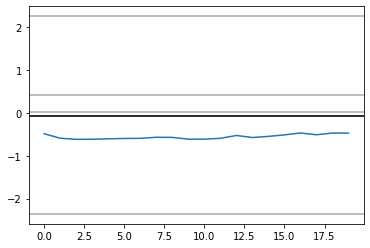

In [32]:
ev_nn = eigenvalue_evolution[-1]
closest_true_ev = eigenvalues[(np.abs(eigenvalues - ev_nn)).argmin()]
plt.plot(eigenvalue_evolution)
for ev in eigenvalues:
    plt.axhline(y=ev, color="darkgray")
    
plt.axhline(y=closest_true_ev, color="k")
plt.show()